# DATA EXPLORATION AND CLEANING WITH PYSPARK

## Notes

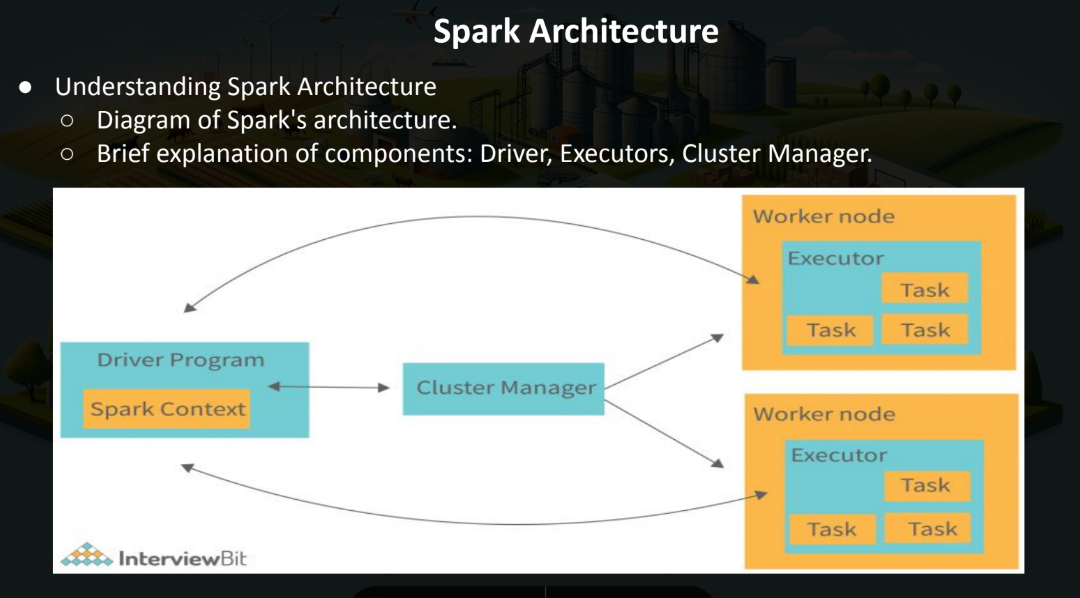

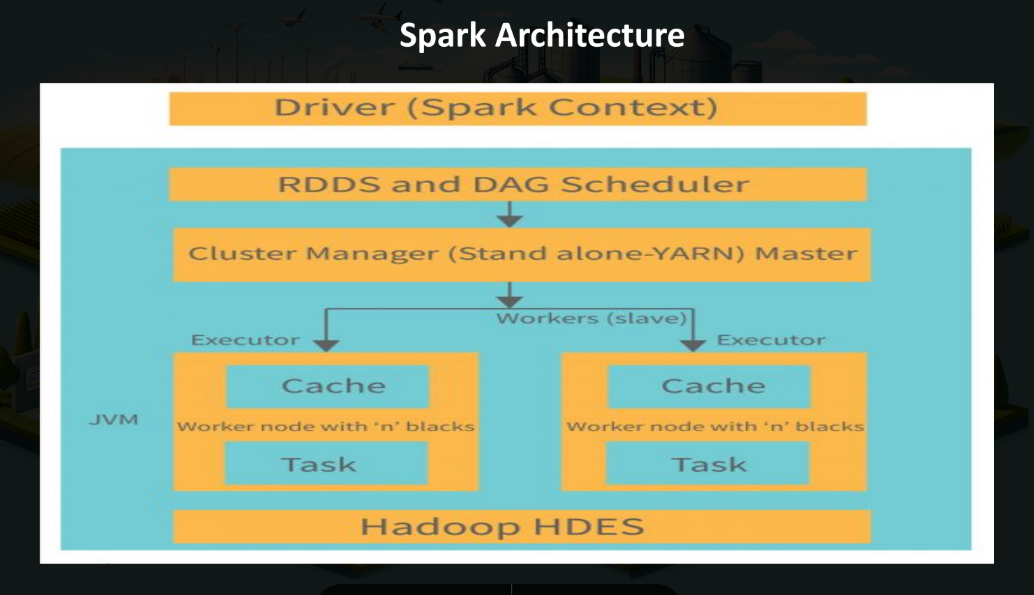

In [1]:
from IPython.display import display, Image 
display(Image("spark_architecture1.png"))
display(Image("spark_architecture.png"))

- **Advantages of Spark :** Spark  is  known  to  handles  large-scale  data  processing  and  it  has  efficient  architecture 
(Driver, Executors, Cluster Manager).
>- Speed: Spark performs up to 100 times faster than MapReduce for processing large amounts of data. It is also able to divide the data into chunks in a controlled way.
>- Powerful Caching: Powerful caching and disk persistence capabilities are offered by a simple programming layer.(in memory)
>- Deployment: Mesos, Hadoop via YARN, or Spark’s own cluster manager can all be used to deploy it.
>- Real-Time: Because of its in-memory processing, it offers real-time computation and low latency.
>- Polyglot:  In  addition  to  Java,  Scala,  Python,  and  R,  Spark  also  supports  all  four  of these languages. You can write spark code in any one of these languages. 
>- Spark also provides a command-line interface in Scala and Python.

-  **Cleaning Techniques in Spark**
>- Filtering data.
>- Aggregations and GroupBy.
>- Joining DataFrames

## Case Study

### Case Study Summary: Data Exploration & Cleaning with PySpark

**1. Overview**
This case study highlights how **Nuga Bank**, a prominent financial institution, adopted **PySpark** to enhance its data exploration and cleaning workflows. The initiative focused on automating data preparation to support better analysis and decision-making.

---

**2. Key Challenges**
- Manual, time-consuming data cleaning processes.
- Poor scalability with increasing data volume.
- Inconsistent data quality impacting analysis.
- Difficulty transforming raw data into structured formats.

---

**3. Objectives**
- Implement automated data exploration and cleaning using **PySpark**.
- Normalize datasets to **2NF or 3NF** for better integrity.
- Load structured data into a **PostgreSQL** database for reporting and analysis.

---

**4. Implementation Steps**

- 1. **Data Extraction**
>- Setup **Spark Context** for distributed computing.
>- Load CSV data into **PySpark DataFrame**.

- 2. **Data Transformation**
>- Handle missing values, duplicates, and inconsistent formats.
>- Normalize data into relational schema.

- 3. **Data Loading**
>- Store the cleaned and normalized data in a **PostgreSQL Server**.

---

**5. Benefits**
>- **Efficiency**: Reduced manual tasks via automation.
>- **Scalability**: Able to process large datasets with ease.
>- **Data Quality**: Standardized and consistent data cleaning.
>- **Structured Database**: Easier data management and querying.
>- **Team Collaboration**: Shared workflows improved communication and efficiency.

---

**6. Tech Stack**
>- **Programming Languages**: Python, SQL  
>- **Processing Framework**: PySpark  
>- **Database**: PostgreSQL  

---

**7. 🔗 Data Source**
>- [Google Drive - Dataset](https://drive.google.com/file/d/1WvnxUWIUQcRSXB5so7-PoGPxU9ekSkYb/view?usp=sharing)

---

> *The project will successfully automate and scale data exploration and cleaning, empowering Nuga Bank with a robust and efficient data foundation for analytics.*

### Libraries and Dependencies

In [2]:
# Import necessary dependencies
from pyspark.sql import SparkSession # entry point to using DataFrame and SQL functionality in PySpark.
from pyspark.sql.functions import col, monotonically_increasing_id # Great for joining, tracking, or indexing rows when no natural unique key exists.
import pandas as pd
import gdown
import os
import tempfile
import shutil
from dotenv import load_dotenv
load_dotenv()
import psycopg2
from psycopg2 import sql
from sqlalchemy import create_engine, Column, Integer, String, Float, BigInteger, Text, TIMESTAMP, ForeignKey, MetaData, Table

### Extraction Layer

In [ ]:
# Initialise  Spark Session
spark = SparkSession.builder.appName('NugaBankEtl').getOrCreate()
spark

In [ ]:
# Download CSV content from Google Drive into a temporary file path 

with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as tmp:
    temp_path = tmp.name

file_id = "1WvnxUWIUQcRSXB5so7-PoGPxU9ekSkYb"
gdown.download(f"https://drive.google.com/uc?id={file_id}", temp_path, quiet=False)

shutil.copy(temp_path, "nuga_bank_transactions.csv") # Save a permanent copy of the downloaded CSV

nuga_bank_df = spark.read.csv(temp_path, header=True, inferSchema=True) # Load into Spark
nuga_bank_df.cache()  # Force read and keep in memory
nuga_bank_df.count()  # Triggers actual file read


os.remove(temp_path) # delete temp file

# Show details
print(f"Data Shape: {nuga_bank_df.count()} rows × {len(nuga_bank_df.columns)} columns")
nuga_bank_df.show(5)
nuga_bank_df.printSchema()

### Transformation Layer

In [ ]:
#nuga_bank_df = spark.read.csv(r'nuga_bank_transactions.csv', header=True, inferSchema=True)

#### Checking for null values

In [ ]:
# Checking for null values
for col in nuga_bank_df.columns:
    print(f"{col}: {nuga_bank_df.filter(nuga_bank_df[col].isNull()).count()} nulls")


**NULL HANDLING STRATEGY**
| Column Category          | Columns                                                                                                                                         | Strategy                                                                                                     |
| ------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| ✅ Mandatory & Critical   | `Transaction_Date`, `Amount`, `Transaction_Type`                                                                                                | Already non-null — **no action** needed.                                                                     |
| 📌 High-Value Optional   | `Currency_Code`, `Category`, `Group`, `Is_Active`, `Random_Number`, `Last_Updated`                                                              | - Use `fillna()` with `"Unknown"` or `"N/A"` for strings<br>- Use `-1` or a flagged number for numerics      |
| Customer Profile      | `Customer_Name`, `Customer_Address`, `Customer_City`, `Customer_State`, `Customer_Country`, `Email`, `Phone_Number`, `Gender`, `Marital_Status` | - Use `"Unknown"`  for strings<br>- Optionally drop rows with **≥5 nulls** across these fields |
| Financial Identifiers | `Credit_Card_Number`, `IBAN`                                                                                                                    | - Drop these **if not needed downstream** or mask with `"0000-0000-0000-0000"` / `"UNKNOWN"`                 |
| Employment Data    | `Company`, `Job_Title`                                                                                                                          | - Fill missing with `"Undisclosed"`                                                        |
| Description           | `Description`                                                                                                                                   | - Fill with `"No description provided"`  placeholder                                                |


In [ ]:
# 1. Fill common categorical string fields
string_fill = {
    "Customer_Name": "Unknown",
    "Customer_Address": "Unknown",
    "Customer_City": "Unknown",
    "Customer_State": "Unknown",
    "Customer_Country": "Unknown",
    "Email": "unknown@example.com",
    "Phone_Number": "Unknown",
    "Company": "Undisclosed",
    "Job_Title": "Unemployed",
    "Currency_Code": "N/A",
    "Category": "N/A",
    "Group": "N/A",
    "Is_Active": "Unknown",
    "Description": "No description provided",
    "Gender": "Unspecified",
    "Marital_Status": "Unspecified",
    "IBAN": "Unknown"
}
nuga_bank_df_clean = nuga_bank_df.fillna(string_fill)

In [ ]:
# 2. Fill numerical fields
nuga_bank_df_clean = nuga_bank_df_clean.fillna({
    "Random_Number": -1.0,
    "Credit_Card_Number": 0 
})

In [ ]:
# 3. Fill timestamp
nuga_bank_df_clean = nuga_bank_df_clean.fillna({"Last_Updated": "1900-01-01"})

In [ ]:
#  Convert all column names to lowercase
from pyspark.sql.functions import col
nuga_bank_df_clean = nuga_bank_df_clean.select([col(c).alias(c.lower()) for c in nuga_bank_df_clean.columns])

In [ ]:
# Checking for null values again
for col in nuga_bank_df_clean.columns:
    null_count = nuga_bank_df_clean.filter(nuga_bank_df_clean[col].isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} nulls")

nuga_bank_df_clean.columns

#### Normalise and Split to dim and facts

In [ ]:
dim_customer = nuga_bank_df_clean \
    .select('customer_name', 'customer_address', 'customer_city', 'customer_state', 'customer_country', 'email', 'phone_number') \
    .dropDuplicates() \
    .withColumn("customer_id", monotonically_increasing_id())


dim_customer =dim_customer.select('customer_id','customer_name', 'customer_address', 'customer_city', 'customer_state', 'customer_country', 'email', 'phone_number')
dim_customer.show()

In [ ]:
dim_employee = nuga_bank_df_clean \
    .select('company', 'job_title', 'gender', 'marital_status') \
    .dropDuplicates() \
    .withColumn("employee_id", monotonically_increasing_id())

dim_employee = dim_employee.select('employee_id','company', 'job_title', 'gender', 'marital_status')
dim_employee.show()

In [ ]:
dim_transaction_ctx = nuga_bank_df_clean \
    .select( 'transaction_type','currency_code', 'category', 'group', 'is_active', 'last_updated', 'description') \
    .dropDuplicates() \
    .withColumn("transaction_context_id", monotonically_increasing_id())
dim_transaction_ctx = dim_transaction_ctx.select('transaction_context_id','transaction_type','currency_code', 'category', 'group', 'is_active', 'last_updated', 'description')
dim_transaction_ctx.show()

In [ ]:
fact_transaction = nuga_bank_df_clean \
    .join(dim_customer, on=['customer_name', 'customer_address', 'customer_city', 'customer_state', 'customer_country', 'email', 'phone_number'], how='left') \
    .join(dim_employee, on=['company', 'job_title', 'gender', 'marital_status'], how='left') \
    .join(dim_transaction_ctx, on=['transaction_type','currency_code', 'category', 'group', 'is_active', 'last_updated', 'description'], how='left') \
    .withColumn("transaction_id", monotonically_increasing_id()) \
    .select('transaction_id', 'customer_id', 'employee_id', 'transaction_context_id',
            'transaction_date', 'amount', 'random_number' ,'credit_card_number', 'iban')

fact_transaction.show()

####  Save the Cleaned Dimension and Fact Tables

In [ ]:
# 1. Set HADOOP_HOME
print("HADOOP_HOME:", os.environ.get("HADOOP_HOME"))
os.environ["HADOOP_HOME"] = "C:\\hadoop-3.2.1"  # Confirm this path exists!

# 2. Add bin directory to PATH
hadoop_bin = os.path.join(os.environ["HADOOP_HOME"], "bin")
os.environ["PATH"] = hadoop_bin + os.pathsep + os.environ["PATH"]

# Check if winutils.exe exists
winutils_path = os.path.join(hadoop_bin, "winutils.exe")
print(f"winutils.exe exists: {os.path.exists(winutils_path)}")

# Check if hadoop.dll exists
hadoop_dll = os.path.join(hadoop_bin, "hadoop.dll")
print(f"hadoop.dll exists: {os.path.exists(hadoop_dll)}")

print("PATH contains Hadoop bin:", r"C:\hadoop-3.2.1\bin" in os.environ["PATH"])

In [ ]:
# Save as Parquet Files (Recommended for DWH / Spark Pipelines)
# Parquet is columnar, efficient for query engines, supports schema, and is splittable.

dim_customer.write.mode("overwrite").parquet("output/dim_customer")
dim_employee.write.mode("overwrite").parquet("output/dim_employee")
dim_transaction_ctx.write.mode("overwrite").parquet("output/dim_transaction_context")
fact_transaction.write.mode("overwrite").parquet("output/fact_transactions")


In [ ]:
'''# Example: Write to HDFS instead of local
dim_customer.write.mode("overwrite").parquet("hdfs:///output/dim_customer")
dim_employee.write.mode("overwrite").parquet("hdfs:///output/dim_employee")
dim_transaction_ctx.write.mode("overwrite").parquet("hdfs:///output/dim_transaction_context")
fact_transaction.write.mode("overwrite").parquet("hdfs:///output/fact_transactions")

# output the transformed data as csv
transaction.repartition(1).write.mode('overwrite').option('header', 'true').csv(r'dataset/transformeddata/csv/transaction')
customer.repartition(1).write.mode('overwrite').option('header', 'true').csv(r'dataset/transformeddata/csv/customer')
employee.repartition(1).write.mode('overwrite').option('header', 'true').csv(r'dataset/transformeddata/csv/employee')
fact_table.repartition(1).write.mode('overwrite').option('header', 'true').csv(r'dataset/transformeddata/csv/fact_table')

# Convert to Pandas DataFrames (For Lightweight BI or Local Analysis)
# Useful if you want to do quick analysis or load into something like Power BI/Excel.

df_customer = dim_customer.toPandas()
df_employee = dim_employee.toPandas()
dim_transaction_ctx = dim_transaction_ctx.toPandas()
fact_transaction = fact_transaction.toPandas()'''

In [ ]:
# Stop existing session
spark.stop()

### Loading Layer

- Load to a Target Destination (optional based on use-case)
>- To a Database: Load into PostgreSQL, BigQuery, Redshift, etc.
>- To a Data Lake: Save to cloud storage like AWS S3, Azure Blob, GCS.

####  Load into PostgreSQL or Upload to Cloud Storage (e.g., Amazon S3)

##### Connect to db

In [3]:
try:
    # Load DB URL and target schema name
    db_url = os.getenv("NUGA_BANK")
    target_schema = "olap"

    # Initialize SQLAlchemy engine and psycopg2 connection
    engine = create_engine(db_url)
    conn = psycopg2.connect(db_url)
    conn.autocommit = True
    cursor = conn.cursor()

    # Define metadata with schema
    metadata = MetaData(schema=target_schema)

    print("✅ Database engine created successfully.")

    # Create schema if it does not exist
    cursor.execute(
        sql.SQL("CREATE SCHEMA IF NOT EXISTS {}").format(sql.Identifier(target_schema))
    )

    print(f"✅ Schema '{target_schema}' created or already exists.")

except Exception as e:
    print("❌ Failed to create database engine or schema:", e)
    engine = None



✅ Database engine created successfully.
✅ Schema 'olap' created or already exists.


#####   Create Tables with Primary/Foreign Keys

In [4]:
# Define tables
dim_customer = Table(
    'dim_customer', metadata,
    Column('customer_id', BigInteger, primary_key=True, autoincrement=True),
    Column('customer_name', Text),
    Column('customer_address', Text),
    Column('customer_city', Text),
    Column('customer_state', Text),
    Column('customer_country', Text),
    Column('email', Text),
    Column('phone_number', Text)
)

dim_employee = Table(
    'dim_employee', metadata,
    Column('employee_id', BigInteger, primary_key=True, autoincrement=True),
    Column('company', Text),
    Column('job_title', Text),
    Column('gender', Text),
    Column('marital_status', Text)
)

dim_transaction_context = Table(
    'dim_transaction_context', metadata,
    Column('transaction_context_id', BigInteger, primary_key=True, autoincrement=True),
    Column('transaction_type', Text),
    Column('currency_code', Text),
    Column('category', Text),
    Column('group', Text),
    Column('is_active', Text),
    Column('last_updated', TIMESTAMP),
    Column('description', Text)
)

fact_transaction = Table(
    'fact_transaction', metadata,
    Column('transaction_id', BigInteger, primary_key=True, autoincrement=True),
    Column('customer_id', BigInteger, ForeignKey('dim_customer.customer_id')),
    Column('employee_id', BigInteger, ForeignKey('dim_employee.employee_id')),
    Column('transaction_context_id', BigInteger, ForeignKey('dim_transaction_context.transaction_context_id')),
    Column('transaction_date', TIMESTAMP),
    Column('amount', Float),
    Column('random_number', Float),
    Column('credit_card_number', BigInteger),
    Column('iban', Text)
)

# Create all tables
try:
    metadata.create_all(engine)
    print("✅ Tables created successfully.")
except Exception as e:
    print(f"❌ Error creating tables: {e}")


✅ Tables created successfully.


##### ERD

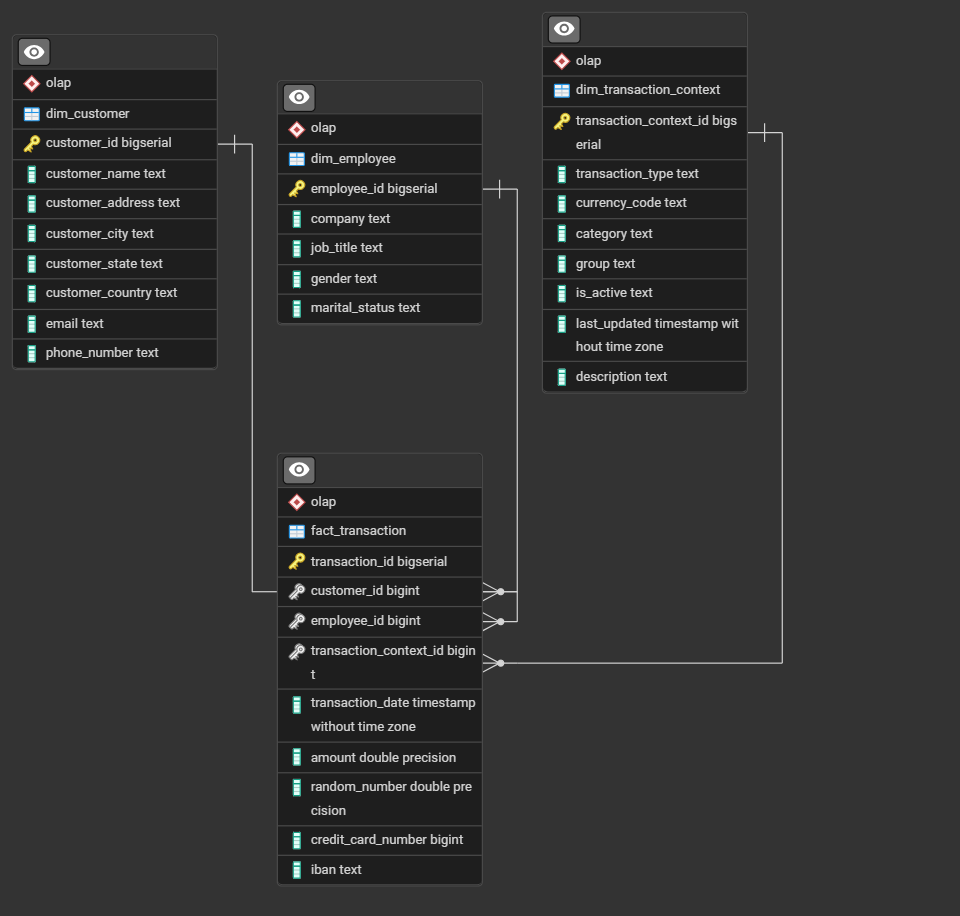

In [5]:
display(Image("datamodel.png"))

In [6]:
# Load from .parquet and Upload to DB (PostgreSQL)

if engine:
    try:

        # Load from saved parquet
      dim_customer_df = pd.read_parquet("output/dim_customer")
      dim_employee_df = pd.read_parquet("output/dim_employee")
      dim_transaction_ctx_df = pd.read_parquet("output/dim_transaction_context")
      fact_transaction_df = pd.read_parquet("output/fact_transactions")

        # Write to PostgreSQL
      dim_customer_df.to_sql("dim_customer", engine, if_exists="append", schema=target_schema, index=False)
      dim_employee_df.to_sql("dim_employee", engine, if_exists="append", schema=target_schema,index=False)
      dim_transaction_ctx_df.to_sql("dim_transaction_context", engine, if_exists="append",schema=target_schema, index=False)
      fact_transaction_df.to_sql("fact_transaction", engine, if_exists="append",schema=target_schema, index=False)

      print("✅ All tables written to the database.")
    except Exception as e:
      print("❌ Failed to load or write Parquet tables:", e)


❌ Failed to load or write Parquet tables: (psycopg2.errors.ForeignKeyViolation) insert or update on table "fact_transaction" violates foreign key constraint "fact_transaction_employee_id_fkey"
DETAIL:  Key (employee_id)=(42949781054) is not present in table "dim_employee".

[SQL: INSERT INTO olap.fact_transaction (transaction_id, customer_id, employee_id, transaction_context_id, transaction_date, amount, random_number, credit_card_number, iban) VALUES (%(transaction_id__0)s, %(customer_id__0)s, %(employee_id__0)s, %(transacti ... 214833 characters truncated ... on_date__999)s, %(amount__999)s, %(random_number__999)s, %(credit_card_number__999)s, %(iban__999)s)]
[parameters: {'random_number__0': -1.0, 'transaction_id__0': 0, 'employee_id__0': 60129570329, 'customer_id__0': 34359776183, 'credit_card_number__0': 30354972356468, 'iban__0': 'GB21OBJC83341529744090', 'transaction_context_id__0': 39347, 'amount__0': 129.83, 'transaction_date__0': datetime.datetime(2024, 3, 20, 22, 44, 9, 8288